In [1]:
import numpy as np
import time
import os
import cv2
import sys

In [2]:
os.getcwd()
home_dir = os.path.abspath('../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac', 'small-data')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

In [3]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X_c, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X_c, length_per_mvi)

print("Total time to load small-data is", time.time() - start_time, "seconds")

  0%|          | 2/10421 [00:00<11:35, 14.98it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [02:22<00:00, 73.36it/s]
1it [00:00,  3.08it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  3.00it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:00,  3.71it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  3.50it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  3.05it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:01,  3.08it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  3.10it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


10it [00:02,  3.46it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821
MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.62it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:03,  2.77it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.34it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small-data is 146.36612367630005 seconds


In [4]:
# Divide the data into train, test

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    train_index_end = int(len(X) * 0.8)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

Xc_train, Xc_test, Y_train_dict, Y_test_dict = _split_train_test(X_c, Y_dict)

(540, 960, 3)
(540, 960, 3)


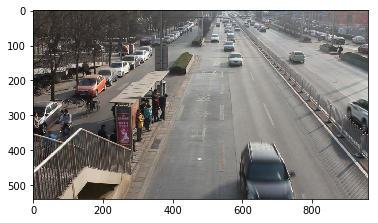

In [6]:
import matplotlib.pyplot as plt
import random
image_index = 0 #random.randint(0,100) # You may select anything up to 60,000
print(Xc_train[image_index].shape)

example = Xc_train[image_index]
print(example.shape)

plt.imshow(example)

In [7]:
# We might need to manually load the dataset annotations because now we need bounding boxes
import time
import os
import numpy as np
import xml.etree.ElementTree as ET
import cv2
import random
from tqdm import tqdm
    
def load_XML_bounding_boxes(anno_dir, images, length_per_mvi,
               random_ = {'vehicle_type': False, 'speed': False, 'intersection': True, 'color': True}):
    """
    Loads the annotations for UADETRAC
    :param anno_dir: annotation directry
    :param images: loaded image matrix
    :param length_per_mvi: number of samples per mvi folder
    :param random_: whether to load the labels as random
    :return: label dict
    """
    n_samples, _, _, _ = images.shape
    anno_files = os.listdir(anno_dir)
    anno_files.sort()
    assert(len(anno_files) == len(length_per_mvi))
    bounding_boxes = []

    length_cumulative = 0

    for idx, anno_file in tqdm(enumerate(anno_files)):
        #each anno_file will be organized by mvi
        file_path = os.path.join(anno_dir, anno_file)

        if ".swp" in file_path:
            continue
        tree = ET.parse(file_path)
        tree_root = tree.getroot()

        prev_frame_num = 1

        for frame in tree_root.iter('frame'):
            curr_frame_num = int(frame.attrib['num'])
            if curr_frame_num != prev_frame_num + 1:
                bounding_boxes.extend([None] * (curr_frame_num - (prev_frame_num + 1) ))

            prev_frame_num = curr_frame_num

            bboxes = []
            for box in frame.iter('box'):
                left = int(eval(box.attrib['left']))
                top = int(eval(box.attrib['top']))
                right = left + int(eval(box.attrib['width']))
                bottom = top + int(eval(box.attrib['height']))
                bboxes.append((left, top, right, bottom))
            bounding_boxes.append(bboxes)
            ## Color




        if prev_frame_num != length_per_mvi[idx]:
            bounding_boxes.extend([None]* (length_per_mvi[idx] - prev_frame_num))


        length_cumulative += length_per_mvi[idx]
        print(anno_file)
        print("mvi length:", length_cumulative)
        
    return bounding_boxes


Y_bounding_boxes = load_XML_bounding_boxes(anno_dir, X_c, length_per_mvi)

1it [00:00,  2.59it/s]

MVI_20011.xml
mvi length: 664


4it [00:00,  3.31it/s]

MVI_20012.xml
mvi length: 1600
MVI_20032.xml
mvi length: 2037
MVI_20033.xml
mvi length: 2821


5it [00:01,  3.16it/s]

MVI_20034.xml
mvi length: 3621


6it [00:01,  3.01it/s]

MVI_20035.xml
mvi length: 4421


7it [00:02,  2.99it/s]

MVI_20051.xml
mvi length: 5327


8it [00:02,  3.09it/s]

MVI_20052.xml
mvi length: 6021


10it [00:02,  3.54it/s]

MVI_20061.xml
mvi length: 6821
MVI_20062.xml
mvi length: 7621


11it [00:03,  3.71it/s]

MVI_20063.xml
mvi length: 8421


12it [00:03,  2.89it/s]

MVI_20064.xml
mvi length: 9221


13it [00:04,  2.50it/s]

MVI_20065.xml
mvi length: 10421


In [19]:
print(Y_bounding_boxes[0])
print(Y_bounding_boxes[:3])

[(592, 378, 752, 540), (557, 120, 604, 163), (545, 88, 580, 118), (508, 67, 536, 92), (553, 70, 582, 89), (731, 114, 783, 153), (902, 250, 960, 357)]
[[(592, 378, 752, 540), (557, 120, 604, 163), (545, 88, 580, 118), (508, 67, 536, 92), (553, 70, 582, 89), (731, 114, 783, 153), (902, 250, 960, 357)], [(594, 391, 755, 540), (557, 121, 605, 165), (545, 88, 580, 118), (508, 67, 536, 93), (553, 70, 582, 90), (729, 112, 780, 151), (894, 238, 960, 345)], [(598, 406, 760, 540), (557, 122, 606, 167), (544, 88, 580, 119), (508, 68, 536, 94), (553, 70, 582, 90), (728, 111, 778, 150), (884, 234, 960, 333)]]


In [8]:


def crop(image, bounding_boxes_per_frame):
    crops = []
    
    

    for bounding_box in bounding_boxes_per_frame:
        left = bounding_box[0]
        top = bounding_box[1]
        right = bounding_box[2]
        bottom = bounding_box[3]
        cropped_image = image[top:bottom, left:right,:]
        crops.append(cropped_image)

        
    return crops

In [9]:
images_to_play = Xc_train[:100]
bounding_to_play = Y_bounding_boxes[:100]

n_samples, height, width, channels = images_to_play.shape
#let's start cropping the images
cropped_images = []
count = 0
for i in range(n_samples):
    cropped_images_per_frame = crop(images_to_play[i,:,:,:], bounding_to_play[i])
    cropped_images.append(cropped_images_per_frame)
    count += len(cropped_images_per_frame)
    



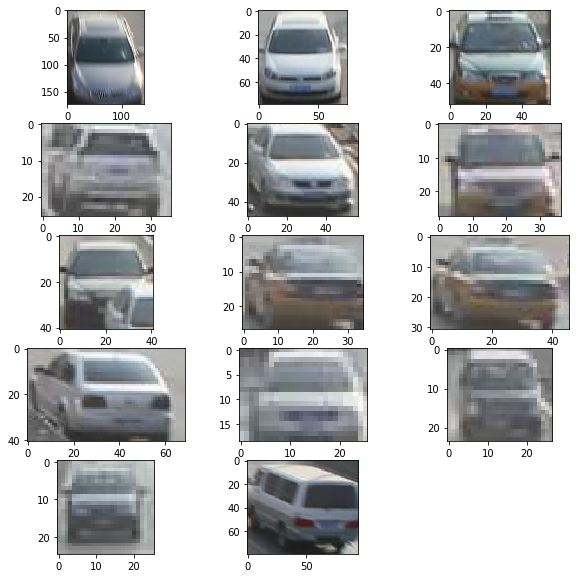

In [10]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 5

for i in range(len(cropped_images[99])):

    fig.add_subplot(rows, columns, i + 1)
    example = cropped_images[99][i]
    plt.imshow(example)
plt.show()



In [17]:
def convert(ori_val):
    return int(ori_val * 256 / 100)

"""

def assign_color(hist):
    silver_low = convert(41)
    silver_high = convert(55)
    black_low = convert(0)
    black_high = convert(40)
    white_low = convert(61)
    white_high = convert(100)
    threshold = 0.2
    debug = []
    
    #we expect a 256,1 array
    total = sum(hist)
    silver_perc = sum(hist[silver_low:silver_high, 0]) / total
    black_perc = sum(hist[black_low:black_high, 0]) / total
    white_perc = sum(hist[white_low:white_high, 0]) / total
    
    percs = [silver_perc, black_perc, white_perc]
    #naturally, silver should be great because the roads are silver
    
    color_arr = ['silver', 'black', 'white']
    max_color = color_arr[percs.index(max(percs))]
    debug.append(percs)
    if max(percs) > threshold:
        return max_color, debug
    else:
        return 'none', debug


"""
def condition_check(h,s,v):
    
    black_low = convert(0)
    black_high = convert(40)
    silver_low = convert(41)
    silver_high = convert(55)
    white_low = convert(61)
    white_high = convert(100)
    h_th = 30
    s_th = 30
    
    black_count = 0
    silver_count = 0
    white_count = 0
    if v >= black_low and v <= black_high and h < h_th and s < s_th:
        black_count += 1
    elif v >= silver_low and v <= silver_high and h < h_th and s < s_th:
        silver_count += 1
    elif v >= white_low and v <= white_high and h < h_th and s < s_th:
        white_count += 1
    
    return (silver_count, black_count, white_count)
        
        

def assign_color(hue_arr, sat_arr, value_arr):
    debug = []
    threshold = 0.2
    
    hue_arr_flatten = np.reshape(hue_arr, (1, -1))
    sat_arr_flatten = np.reshape(sat_arr, (1, -1))
    value_arr_flatten = np.reshape(value_arr, (1, -1))
    
    _, pixel_count = hue_arr_flatten.shape
    
    silver_count = 0
    black_count = 0
    white_count = 0
    
    assert(hue_arr_flatten.shape == sat_arr_flatten.shape)
    assert(hue_arr_flatten.shape == value_arr_flatten.shape)
    
    for i in range(pixel_count):
        s,b,w = condition_check(hue_arr_flatten[0,i], sat_arr_flatten[0,i], value_arr_flatten[0, i])
        silver_count += s
        black_count += b
        white_count += w
    
    total = pixel_count
    silver_perc = silver_count / total
    black_perc = black_count / total
    white_perc = white_count / total
            
    percs = [silver_perc, black_perc, white_perc]
    #naturally, silver should be great because the roads are silver
    
    color_arr = ['silver', 'black', 'white']
    max_color = color_arr[percs.index(max(percs))]
    debug.append(percs)
    if max(percs) > threshold:
        return max_color, debug
    else:
        return 'none', debug
    

colors_all = []
debug_all = []
for cropped_images_per_frame in cropped_images:
    colors_frame = []
    debug_frame = []
    for cropped_image in cropped_images_per_frame:
        hsv = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)
        height, width, channels = hsv.shape
        start_height = int(height * 0.2)
        end_height = int(height * 0.8)
        start_width = int(width * 0.2)
        end_width = int(width * 0.8)
        
        relevant_arr = hsv[start_height:end_height, start_width:end_width,:]
        relevant_hue_arr = relevant_arr[:,:,0]
        relevant_sat_arr = relevant_arr[:,:,1]
        relevant_value_arr = relevant_arr[:,:,2]
        
        
        #print(value_arr)
        #we will only use the values column
        #value_hist = cv2.calcHist([relevant_value_arr], [0], None, [256], [0, 256])
        #print(hist.shape)
        #print("----------------")
        #print(hist)
        
        color, debug = assign_color(relevant_hue_arr, relevant_sat_arr, relevant_value_arr)
        colors_frame.append(color)
        debug_frame.append(debug)
    colors_all.append(colors_frame)
    debug_all.append(debug_frame)
    


        

(162, 160, 3)
(43, 47, 3)
(30, 35, 3)
(25, 28, 3)
(19, 29, 3)
(39, 52, 3)
(107, 58, 3)
(149, 161, 3)
(44, 48, 3)
(30, 35, 3)
(26, 28, 3)
(20, 29, 3)
(39, 51, 3)
(107, 66, 3)
(134, 162, 3)
(45, 49, 3)
(31, 36, 3)
(26, 28, 3)
(20, 29, 3)
(39, 50, 3)
(99, 76, 3)
(118, 171, 3)
(46, 49, 3)
(31, 36, 3)
(27, 28, 3)
(20, 30, 3)
(38, 49, 3)
(103, 80, 3)
(100, 160, 3)
(47, 50, 3)
(32, 37, 3)
(28, 28, 3)
(21, 30, 3)
(38, 48, 3)
(94, 89, 3)
(48, 51, 3)
(32, 37, 3)
(28, 28, 3)
(21, 30, 3)
(37, 48, 3)
(92, 94, 3)
(49, 52, 3)
(33, 37, 3)
(29, 29, 3)
(21, 30, 3)
(37, 47, 3)
(97, 99, 3)
(49, 52, 3)
(33, 37, 3)
(29, 28, 3)
(21, 30, 3)
(36, 46, 3)
(86, 106, 3)
(49, 52, 3)
(33, 38, 3)
(29, 28, 3)
(21, 30, 3)
(36, 46, 3)
(89, 110, 3)
(48, 52, 3)
(33, 38, 3)
(29, 28, 3)
(22, 30, 3)
(36, 45, 3)
(90, 120, 3)
(48, 52, 3)
(34, 38, 3)
(29, 27, 3)
(22, 30, 3)
(35, 45, 3)
(87, 126, 3)
(48, 52, 3)
(34, 38, 3)
(29, 27, 3)
(22, 30, 3)
(35, 44, 3)
(86, 110, 3)
(48, 51, 3)
(34, 38, 3)
(29, 26, 3)
(22, 30, 3)
(34, 44, 3

(67, 100, 3)
(90, 92, 3)
(52, 47, 3)
(42, 42, 3)
(18, 23, 3)
(34, 39, 3)
(35, 45, 3)
(22, 31, 3)
(25, 34, 3)
(37, 51, 3)
(44, 59, 3)
(66, 99, 3)
(19, 26, 3)
(22, 22, 3)
(18, 20, 3)
(93, 93, 3)
(53, 49, 3)
(43, 43, 3)
(17, 24, 3)
(33, 39, 3)
(35, 45, 3)
(23, 31, 3)
(25, 34, 3)
(37, 50, 3)
(44, 59, 3)
(65, 97, 3)
(19, 26, 3)
(22, 23, 3)
(18, 20, 3)
(95, 94, 3)
(53, 51, 3)
(43, 44, 3)
(17, 24, 3)
(32, 39, 3)
(36, 45, 3)
(24, 31, 3)
(24, 34, 3)
(36, 49, 3)
(43, 59, 3)
(63, 96, 3)
(19, 26, 3)
(22, 23, 3)
(19, 20, 3)
(97, 96, 3)
(54, 52, 3)
(44, 45, 3)
(17, 25, 3)
(31, 38, 3)
(36, 45, 3)
(25, 31, 3)
(24, 35, 3)
(36, 49, 3)
(42, 59, 3)
(62, 94, 3)
(19, 26, 3)
(22, 24, 3)
(19, 21, 3)
(100, 97, 3)
(55, 54, 3)
(44, 46, 3)
(16, 25, 3)
(31, 38, 3)
(37, 46, 3)
(26, 30, 3)
(24, 35, 3)
(36, 48, 3)
(42, 59, 3)
(60, 92, 3)
(20, 26, 3)
(22, 25, 3)
(19, 21, 3)
(102, 98, 3)
(55, 55, 3)
(45, 48, 3)
(16, 26, 3)
(30, 38, 3)
(37, 46, 3)
(27, 30, 3)
(23, 35, 3)
(36, 47, 3)
(41, 59, 3)
(59, 91, 3)
(20, 26, 3)
(

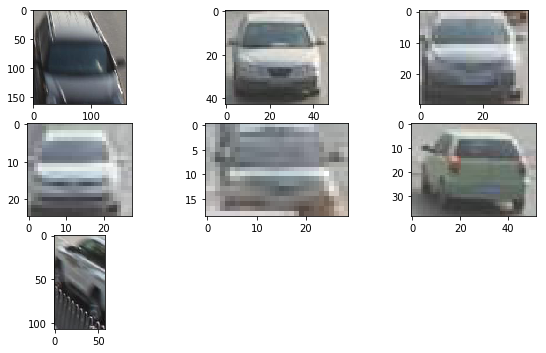

['black', 'silver', 'silver', 'white', 'silver', 'silver', 'black']


In [67]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 5

for i in range(len(cropped_images[0])):

    fig.add_subplot(rows, columns, i + 1)
    example = cropped_images[0][i]
    plt.imshow(example)
plt.show()
print(colors_all[0])

In [68]:
print(debug_all[0])

[[[array([0.16774055], dtype=float32), array([0.6954467], dtype=float32), array([0.07484966], dtype=float32)]], [[array([0.44917583], dtype=float32), array([0.1717033], dtype=float32), array([0.29945055], dtype=float32)]], [[array([0.47354499], dtype=float32), array([0.08465608], dtype=float32), array([0.2936508], dtype=float32)]], [[array([0.23529412], dtype=float32), array([0.03137255], dtype=float32), array([0.46666667], dtype=float32)]], [[array([0.47685185], dtype=float32), array([0.03703704], dtype=float32), array([0.2361111], dtype=float32)]], [[array([0.6814516], dtype=float32), array([0.19489247], dtype=float32), array([0.03494624], dtype=float32)]], [[array([0.37901786], dtype=float32), array([0.521875], dtype=float32), array([0.04285714], dtype=float32)]]]
